In [1]:
import os
import numpy as np
import pickle
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from behavenet.fitting.utils import get_output_session_dir
from behavenet.analyses.decoder_utils import get_r2s_by_trial
from behavenet.analyses.decoder_utils import get_best_models
from behavenet.analyses.decoder_utils import get_r2s_across_trials

save_outputs = False
results_dir = '/home/mattw/results/behavenet_figs/multiregion-decoding'

# 1. Plot decoder performance by region for a single session

### load results

In [2]:
# specify decoder directory
hparams = {
    'data_dir': '/home/mattw/data/',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet/',
    'model_class': 'neural-ae',
    'expt_name': 'grid_search'
    'n_ae_latents': 16,
    'subsample_regions': 'single',
    'lab': 'musall',
    'expt': 'vistrained',
    'animal': 'mSM30',
    'session': '10-Oct-2017',
    'multisession': None,
    'n_ae_latents': 12,
    'n_arhmm_states': 8}
model_types = ['linear', 'ff']  # keep both
metrics_df = get_r2s_by_trial(hparams, model_types):
print('Loaded %i models for analysis' % len(metrics_df))

Loaded 4125 models for analysis


### Plot model performance as a function of lags/layers 
### (take best models over learning rate/L2 reg)

In [3]:
best_models_df = get_best_models(metrics_df)

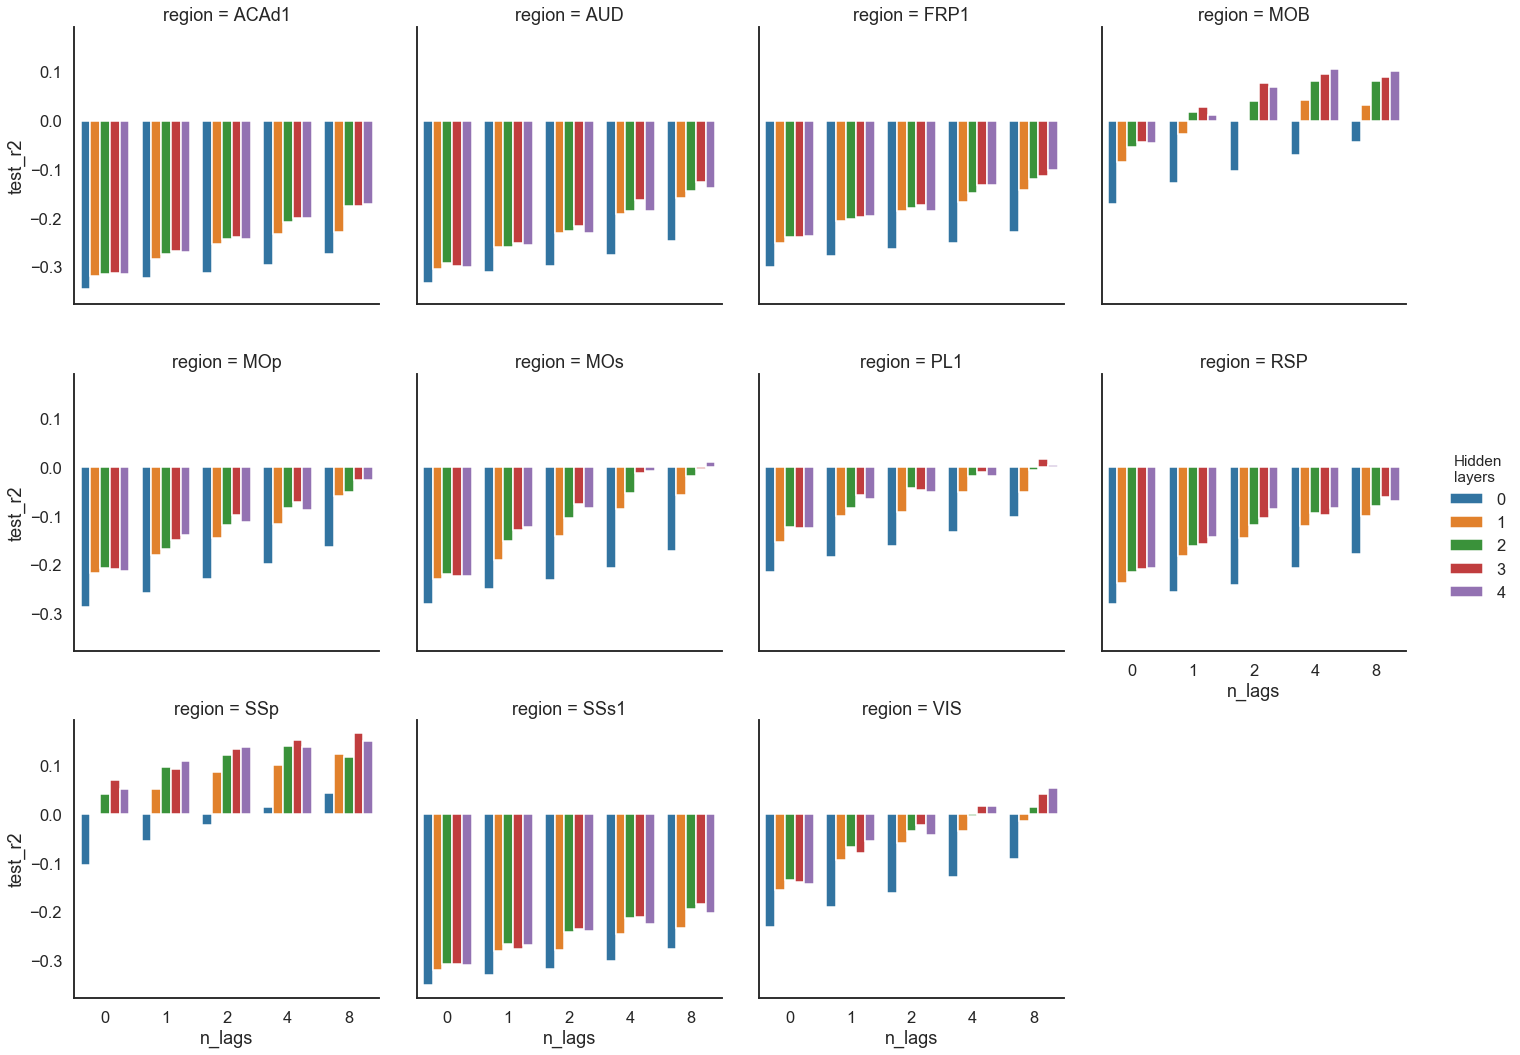

In [4]:
# PLOT
sns.set_style('white'); sns.set_context('talk')
if model_class == 'neural-ae':
    y_axis = 'test_r2' # 'test_loss' | 'test_r2'
    meas_str = 'R2'
    plot_type = 'bar'
elif model_class == 'neural-arhmm':
    y_axis = 'test_fc'
    meas_str = 'FC'
    plot_type = 'boxen'
hue = None if 'ff' not in model_types else 'n_hid_layers'
splt = sns.catplot(
    x='n_lags', y=y_axis, hue=hue, col='region', col_wrap=4,
    kind=plot_type, data=best_models_df, ci=None)
if hue is not None:
    splt._legend.set_title('Hidden\nlayers')
plt.show()

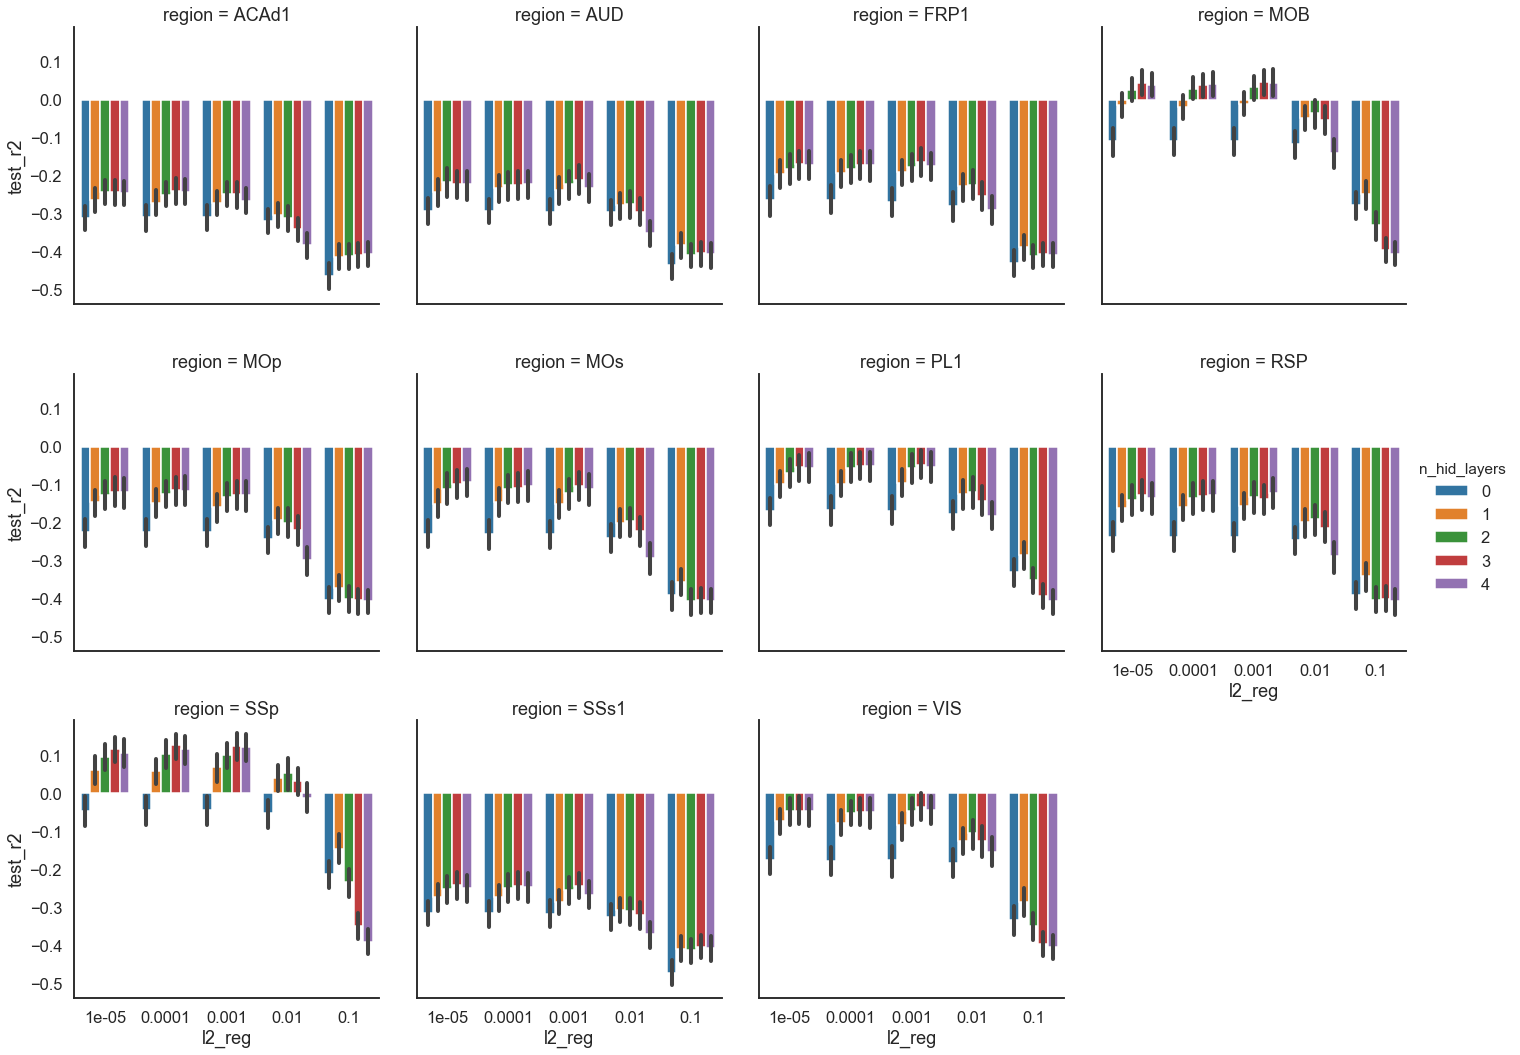

In [5]:
# look at reg vals/learning rate
measure = 'l2_reg'  # 'learning_rate' | 'l2_reg'
get_best = 'l2_reg' if measure == 'learning_rate' else 'learning_rate'
    
# for each version, only keep rows where test_loss is not nan
data_queried = metrics_df[pd.notna(metrics_df.test_loss)]

# group by get_best, find avgs over all other hyperparams
best_meas = data_queried.groupby([get_best]).mean().reset_index()
# find the best value for get_best
best_meas = best_meas[
    best_meas['test_loss']==best_meas['test_loss'].min()][get_best].values[0]
# subsample data with this value
data_queried = data_queried[data_queried[get_best]==best_meas]

splt = sns.catplot(
    x=measure, y='test_r2', hue='n_hid_layers', kind='bar', col='region', 
    col_wrap=4, data=data_queried)

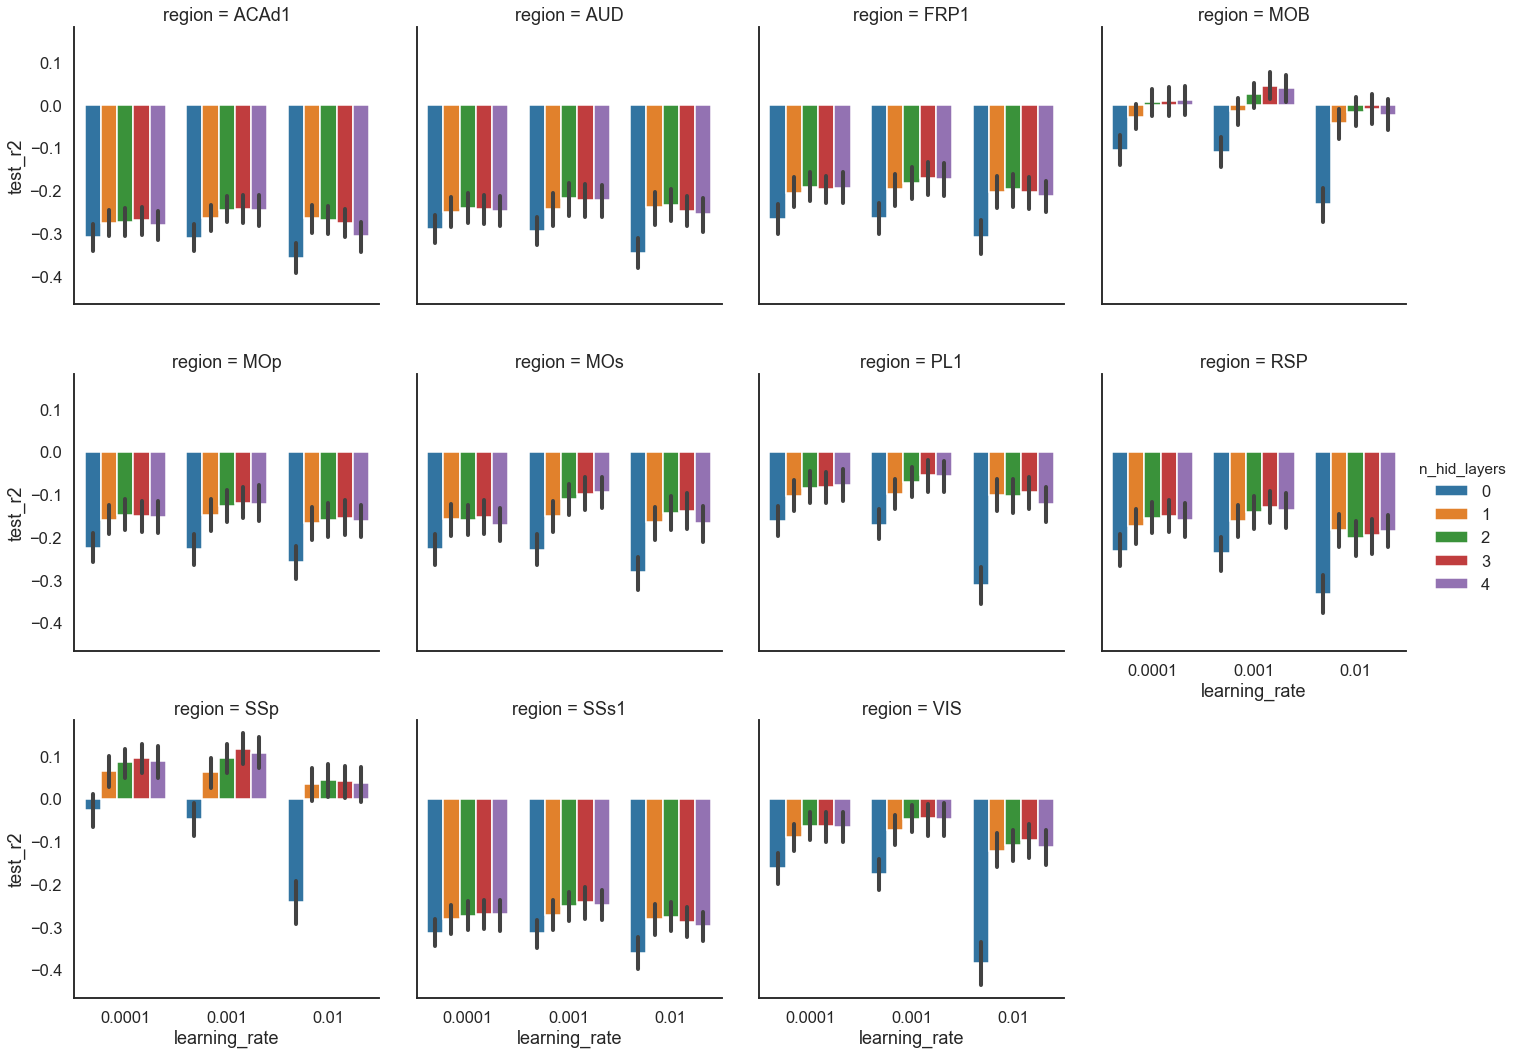

In [6]:
# look at reg vals/learning rate
measure = 'learning_rate'  # 'learning_rate' | 'l2_reg'
get_best = 'l2_reg' if measure == 'learning_rate' else 'learning_rate'
    
# for each version, only keep rows where test_loss is not nan
data_queried = metrics_df[pd.notna(metrics_df.test_loss)]

# group by get_best, find avgs over all other hyperparams
best_meas = data_queried.groupby([get_best]).mean().reset_index()
# find the best value for get_best
best_meas = best_meas[
    best_meas['test_loss']==best_meas['test_loss'].min()][get_best].values[0]
# subsample data with this value
data_queried = data_queried[data_queried[get_best]==best_meas]

splt = sns.catplot(
    x=measure, y='test_r2', hue='n_hid_layers', kind='bar', col='region', 
    col_wrap=4, data=data_queried)

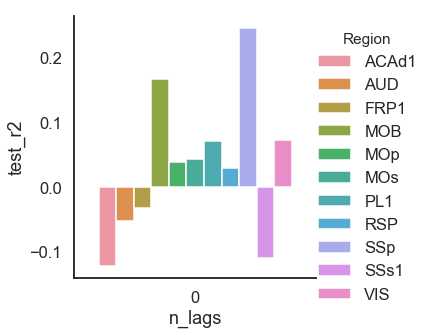

In [22]:
sns.set_style('white'); sns.set_context('talk')
data_queried = metrics_df[pd.notna(metrics_df.test_loss)]
data_queried = data_queried \
    .groupby('version')['region', 'test_r2', 'n_lags'] \
    .agg({'region': pd.Series.mode, 'test_r2': 'median', 'n_lags': lambda x: 0}) \
    .reset_index()
data_queried = data_queried \
    .groupby('region')['test_r2', 'n_lags'].agg('max').reset_index()
splt = sns.catplot(
    x='n_lags', y='test_r2', hue='region', kind='bar', data=data_queried)
# splt.ax.set_ylabel('$R^2$')
# splt.ax.set_xlabel('Neural lags')
if hue is not None:
    splt._legend.set_title('Region')
if save_outputs:
    save_file = os.path.join(results_dir, '%s_decoder_R2s_across_trials' % lab)
else:
    save_file = None
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')   
plt.show()

# 1A. Calculate $R^2$/FC over entire test data for a single session

### get best models from before

In [61]:
save_dfs = True
load_dfs = True

hparams = {
    'data_dir': '/home/mattw/data/',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet/',
    'experiment_name': 'grid_search',
    'model_class': 'neural-ae',
    'n_ae_latents': 16,
    'n_max_lags': 8,
    'subsample_regions': 'single',
    'lab': 'musall',
    'expt': 'vistrained',
    'animal': 'all',
    'session': '',
    'multisession': None}
results_dir_df = os.path.join(hparams['tt_save_path'], hparams['lab'], hparams['expt'])
save_file1 = os.path.join(results_dir_df, 'decoder_R2s_per_trial.pkl')
save_file2 = os.path.join(results_dir_df, 'decoder_R2s_across_trials.pkl')

if load_dfs:
    all_test_r2s_df = pd.load_pickle(save_file2)
else:
    _, sess_ids = get_output_session_dir(hparams)
    model_types = ['linear', 'ff']  # keep both
    all_metrics = []
    all_test_r2s = []
    for sess_id in sess_ids:
        hparams['lab'] = sess_id['lab']
        hparams['expt'] = sess_id['expt']
        hparams['animal'] = sess_id['animal']
        hparams['session'] = sess_id['session']
        dataset = os.path.join(
            sess_id['lab'], sess_id['expt'], sess_id['animal'], sess_id['session'])
        print('%s...' % dataset, end='')
        all_metrics.append(get_r2s_by_trial(hparams, model_types))
        print('loaded %i models for analysis\n' % len(all_metrics[-1].version.unique()))
        best_models_df = get_best_models(all_metrics[-1])
        print('\n\n\n')
        all_test_r2s.append(get_r2s_across_trials(hparams, best_models_df))
    all_metrics_df = pd.concat(all_metrics)
    all_test_r2s_df = pd.concat(all_test_r2s)
    if save_dfs:
    #     all_metrics_df.to_pickle(save_file1)
        all_test_r2s_df.to_pickle(save_file2)

musall/vistrained/mSM30/12-Oct-2017...loaded 1100 models for analysis





Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/linear/ACAd1-single/test_tube_data/grid_search/version_6/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_1/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_3/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_5/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_13/meta_tags.pkl
Loading model defined in 

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_27/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_29/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_42/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_44/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/linear/FRP1-single/test_tube_data/grid_search/version_11/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_l

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_65/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_68/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_70/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/linear/MOB-single/test_tube_data/grid_search/version_7/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_76/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_lat

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_48/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_43/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/linear/MOs-single/test_tube_data/grid_search/version_4/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_52/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_53/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_lat

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_18/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/linear/RSP-single/test_tube_data/grid_search/version_6/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_33/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_48/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_43/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_lat

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/linear/SSs1-single/test_tube_data/grid_search/version_17/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_58/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_59/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_55/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_56/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/12-Oct-2017/neural-ae/

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_6/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_23/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_28/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/linear/ACAd1-single/test_tube_data/grid_search/version_32/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_70/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_210/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_204/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/linear/FRP1-single/test_tube_data/grid_search/version_20/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_90/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_92/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_188/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/linear/MOB-single/test_tube_data/grid_search/version_71/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_211/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_206/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_214/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/1

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/linear/MOs-single/test_tube_data/grid_search/version_53/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_14/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_15/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_20/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_13/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_121/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_122/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_118/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_125/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/linear/RSP-single/test_tube_data/grid_search/version_65/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/1

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_132/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_3/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_90/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/linear/SSs1-single/test_tube_data/grid_search/version_34/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_45/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_13/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_17/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/linear/ACAd1-single/test_tube_data/grid_search/version_2/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_3/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_26/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_77/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/linear/FRP1-single/test_tube_data/grid_search/version_4/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_3/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_7/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_10/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_l

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/linear/MOB-single/test_tube_data/grid_search/version_17/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_60/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_68/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_75/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_78/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_47/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_49/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_58/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_65/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/linear/MOs-single/test_tube_data/grid_search/version_17/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_30/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_50/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_55/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/linear/RSP-single/test_tube_data/grid_search/version_13/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_44/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_17/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_22/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/linear/SSs1-single/test_tube_data/grid_search/version_9/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_30/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_35/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/13-Jan-2018/neural-ae/1

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_16/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/linear/ACAd1-single/test_tube_data/grid_search/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_20/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_23/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_12/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/linear/FRP1-single/test_tube_data/grid_search/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_2/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_9/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_11/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_16/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_62/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_71/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_75/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_77/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/linear/MOp-single/test_tube_data/grid_search/version_1/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_lat

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_50/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_55/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_57/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/linear/MOs-single/test_tube_data/grid_search/version_18/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_58/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_36/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_40/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/linear/RSP-single/test_tube_data/grid_search/version_12/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_49/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_47/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_19/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/linear/SSs1-single/test_tube_data/grid_search/version_9/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_25/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_29/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_34/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/1

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/linear/VIS-single/test_tube_data/grid_search/version_5/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/VIS-single/test_tube_data/grid_search/version_21/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/VIS-single/test_tube_data/grid_search/version_25/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/VIS-single/test_tube_data/grid_search/version_30/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_latents/ff/VIS-single/test_tube_data/grid_search/version_34/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM46/01-Dec-2017/neural-ae/16_lat

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_6/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_11/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_17/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/linear/AUD-single/test_tube_data/grid_search/version_5/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_laten

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_73/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_77/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_78/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/linear/MOB-single/test_tube_data/grid_search/version_4/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_4/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_l

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/MOp-single/test_tube_data/grid_search/version_57/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/MOp-single/test_tube_data/grid_search/version_62/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/linear/MOp-single/test_tube_data/grid_search/version_16/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/MOp-single/test_tube_data/grid_search/version_61/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/MOp-single/test_tube_data/grid_search/version_65/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/PL1-single/test_tube_data/grid_search/version_41/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/linear/PL1-single/test_tube_data/grid_search/version_12/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/PL1-single/test_tube_data/grid_search/version_48/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/PL1-single/test_tube_data/grid_search/version_55/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/PL1-single/test_tube_data/grid_search/version_51/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/linear/SSp-single/test_tube_data/grid_search/version_9/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/SSp-single/test_tube_data/grid_search/version_24/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/SSp-single/test_tube_data/grid_search/version_31/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/SSp-single/test_tube_data/grid_search/version_36/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/SSp-single/test_tube_data/grid_search/version_51/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_lat

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/TEa1-single/test_tube_data/grid_search/version_18/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/TEa1-single/test_tube_data/grid_search/version_8/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/TEa1-single/test_tube_data/grid_search/version_30/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/ff/TEa1-single/test_tube_data/grid_search/version_20/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16_latents/linear/TEa1-single/test_tube_data/grid_search/version_9/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/05-Dec-2017/neural-ae/16

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_6/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_13/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_16/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/linear/ACAd1-single/test_tube_data/grid_search/version_5/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_1/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-a

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_77/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_75/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/linear/FRP1-single/test_tube_data/grid_search/version_3/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_4/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_8/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_63/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/linear/MOB-single/test_tube_data/grid_search/version_17/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_64/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_70/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_76/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/linear/MOs-single/test_tube_data/grid_search/version_12/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_42/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_52/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_55/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_61/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_32/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_30/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_44/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_39/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/linear/RSP-single/test_tube_data/grid_search/version_13/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_25/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_14/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_37/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/linear/SSs1-single/test_tube_data/grid_search/version_8/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_23/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/1

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/VIS-single/test_tube_data/grid_search/version_12/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/VIS-single/test_tube_data/grid_search/version_17/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/linear/VIS-single/test_tube_data/grid_search/version_6/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/VIS-single/test_tube_data/grid_search/version_20/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_latents/ff/VIS-single/test_tube_data/grid_search/version_25/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/neural-ae/16_lat

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_76/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/linear/AUD-single/test_tube_data/grid_search/version_4/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_4/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_6/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_12/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_lat

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/linear/FRP1-single/test_tube_data/grid_search/version_16/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_61/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_66/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_72/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_75/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/MOp-single/test_tube_data/grid_search/version_44/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/MOp-single/test_tube_data/grid_search/version_52/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/MOp-single/test_tube_data/grid_search/version_59/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/MOp-single/test_tube_data/grid_search/version_62/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/linear/MOp-single/test_tube_data/grid_search/version_17/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/PL1-single/test_tube_data/grid_search/version_45/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/PL1-single/test_tube_data/grid_search/version_32/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/PL1-single/test_tube_data/grid_search/version_37/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/linear/PL1-single/test_tube_data/grid_search/version_12/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/PL1-single/test_tube_data/grid_search/version_41/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/SSp-single/test_tube_data/grid_search/version_14/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/SSp-single/test_tube_data/grid_search/version_22/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/linear/SSp-single/test_tube_data/grid_search/version_10/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/SSp-single/test_tube_data/grid_search/version_23/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/SSp-single/test_tube_data/grid_search/version_45/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/VIS-single/test_tube_data/grid_search/version_19/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/linear/VIS-single/test_tube_data/grid_search/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/VIS-single/test_tube_data/grid_search/version_18/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/VIS-single/test_tube_data/grid_search/version_23/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_latents/ff/VIS-single/test_tube_data/grid_search/version_14/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/08-Feb-2018/neural-ae/16_lat

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/linear/AUD-single/test_tube_data/grid_search/version_3/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_3/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_6/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_12/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_15/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_laten

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_57/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_69/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_73/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_78/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/linear/MOB-single/test_tube_data/grid_search/version_4/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/MOp-single/test_tube_data/grid_search/version_50/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/MOp-single/test_tube_data/grid_search/version_54/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/MOp-single/test_tube_data/grid_search/version_65/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/linear/MOp-single/test_tube_data/grid_search/version_18/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/MOp-single/test_tube_data/grid_search/version_62/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/PL1-single/test_tube_data/grid_search/version_51/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/linear/PL1-single/test_tube_data/grid_search/version_12/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/PL1-single/test_tube_data/grid_search/version_46/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/PL1-single/test_tube_data/grid_search/version_49/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/PL1-single/test_tube_data/grid_search/version_56/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/linear/SSp-single/test_tube_data/grid_search/version_8/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/SSp-single/test_tube_data/grid_search/version_41/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/SSp-single/test_tube_data/grid_search/version_30/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/SSp-single/test_tube_data/grid_search/version_49/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/SSp-single/test_tube_data/grid_search/version_54/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_lat

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/TEa1-single/test_tube_data/grid_search/version_21/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/TEa1-single/test_tube_data/grid_search/version_7/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/TEa1-single/test_tube_data/grid_search/version_28/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/ff/TEa1-single/test_tube_data/grid_search/version_34/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16_latents/linear/TEa1-single/test_tube_data/grid_search/version_8/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM57/02-Feb-2018/neural-ae/16

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_6/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_14/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_19/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/linear/ACAd1-single/test_tube_data/grid_search/version_3/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_20/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_73/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_72/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/linear/FRP1-single/test_tube_data/grid_search/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_8/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_56/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/linear/MOB-single/test_tube_data/grid_search/version_17/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_62/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_65/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_74/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/linear/MOs-single/test_tube_data/grid_search/version_14/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_45/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_51/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_58/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_56/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_39/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_45/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_33/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_40/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/linear/RSP-single/test_tube_data/grid_search/version_14/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_22/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_15/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_20/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/linear/SSs1-single/test_tube_data/grid_search/version_8/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_27/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/1

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/VIS-single/test_tube_data/grid_search/version_12/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/VIS-single/test_tube_data/grid_search/version_15/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/linear/VIS-single/test_tube_data/grid_search/version_5/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/VIS-single/test_tube_data/grid_search/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_latents/ff/VIS-single/test_tube_data/grid_search/version_25/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/01-Dec-2017/neural-ae/16_late

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_78/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/linear/AUD-single/test_tube_data/grid_search/version_1/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_4/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_5/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_14/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_lat

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/linear/FRP1-single/test_tube_data/grid_search/version_16/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_58/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_69/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_68/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/FRP1-single/test_tube_data/grid_search/version_73/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/MOp-single/test_tube_data/grid_search/version_45/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/MOp-single/test_tube_data/grid_search/version_51/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/MOp-single/test_tube_data/grid_search/version_56/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/MOp-single/test_tube_data/grid_search/version_62/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/linear/MOp-single/test_tube_data/grid_search/version_17/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/PL1-single/test_tube_data/grid_search/version_34/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/PL1-single/test_tube_data/grid_search/version_32/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/PL1-single/test_tube_data/grid_search/version_37/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/linear/PL1-single/test_tube_data/grid_search/version_14/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/PL1-single/test_tube_data/grid_search/version_50/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_la

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/SSp-single/test_tube_data/grid_search/version_13/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/SSp-single/test_tube_data/grid_search/version_20/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/linear/SSp-single/test_tube_data/grid_search/version_8/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/SSp-single/test_tube_data/grid_search/version_26/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/SSp-single/test_tube_data/grid_search/version_31/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_lat

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/TEa1-single/test_tube_data/grid_search/version_17/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/linear/TEa1-single/test_tube_data/grid_search/version_5/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/TEa1-single/test_tube_data/grid_search/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/TEa1-single/test_tube_data/grid_search/version_9/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_latents/ff/TEa1-single/test_tube_data/grid_search/version_15/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM34/02-Dec-2017/neural-ae/16_

/home/mattw/anaconda3/envs/behavenet/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



### plot by lags/layers across all regions (errorbars over datasets)

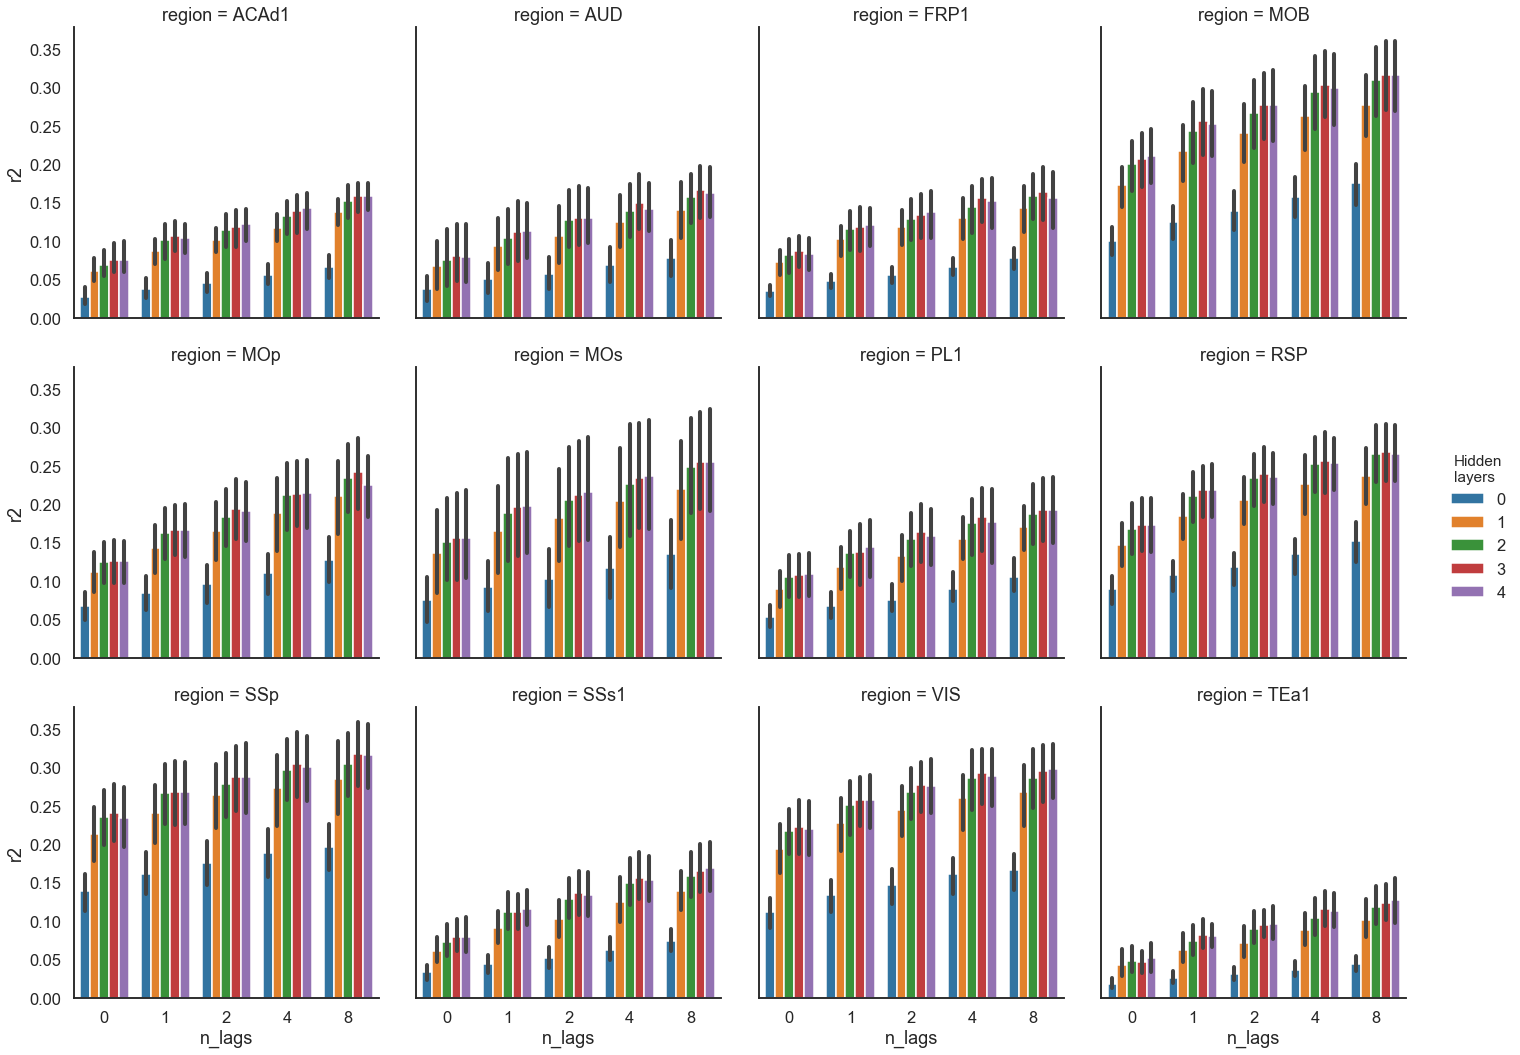

In [64]:
sns.set_style('white'); sns.set_context('talk')
splt = sns.catplot(
    x='n_lags', y='r2', hue='n_hid_layers', col='region', col_wrap=4,
    kind='bar', data=all_test_r2s_df)
# splt.ax.set_ylabel('$R^2$')
# splt.ax.set_xlabel('Neural lags')
splt._legend.set_title('Hidden\nlayers')
# splt.ax.set_ylim([-0.1, 0.2])
if save_outputs:
    save_file = os.path.join(
        results_dir, '%s_decoder_R2s_by_region-layer-lag' % hparams['lab'])
else:
    save_file = None
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')
plt.show()

### plot best model for each region (errorbars over datasets)

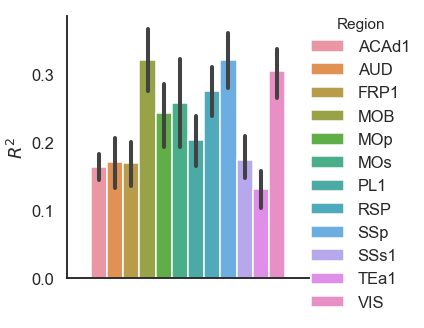

In [65]:
sns.set_style('white'); sns.set_context('talk')
data_queried = all_test_r2s_df.groupby(['region', 'dataset']).max().reset_index()
splt = sns.catplot(
    x='n_lags', y='r2', hue='region', kind='bar', data=data_queried)
# splt.ax.set_ylabel('$R^2$')
# splt.ax.set_xlabel('Neural lags')
splt._legend.set_title('Region')
splt.axes[0, 0].set_ylabel('$R^2$')
splt.axes[0, 0].set_xlabel('')
splt.axes[0, 0].set_xticklabels('')
# splt.ax.set_ylim([-0.1, 0.2])
if save_outputs:
    save_file = os.path.join(
        results_dir, '%s_decoder_R2s_by_region' % hparams['lab'])
else:
    save_file = None
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')    
plt.show()

### plot best model for each region/model type (errorbars over datasets)

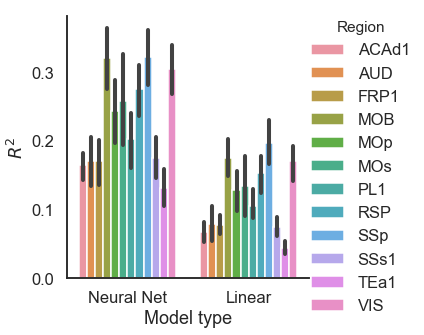

In [66]:
sns.set_style('white'); sns.set_context('talk')
data_queried = all_test_r2s_df.groupby(['region', 'dataset', 'model_type']).max().reset_index()
splt = sns.catplot(
    x='model_type', y='r2', hue='region', kind='bar', data=data_queried)
# splt.ax.set_ylabel('$R^2$')
# splt.ax.set_xlabel('Neural lags')
splt._legend.set_title('Region')
# splt.ax.set_ylim([-0.1, 0.2])
splt.axes[0, 0].set_ylabel('$R^2$')
splt.axes[0, 0].set_xlabel('Model type')
splt.axes[0, 0].set_xticklabels(['Neural Net', 'Linear'])
if save_outputs:
    save_file = os.path.join(
        results_dir, '%s_decoder_R2s_by_region-model' % hparams['lab'])
else:
    save_file = None
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')    
plt.show()

### plot best model for each region (one panel per dataset)

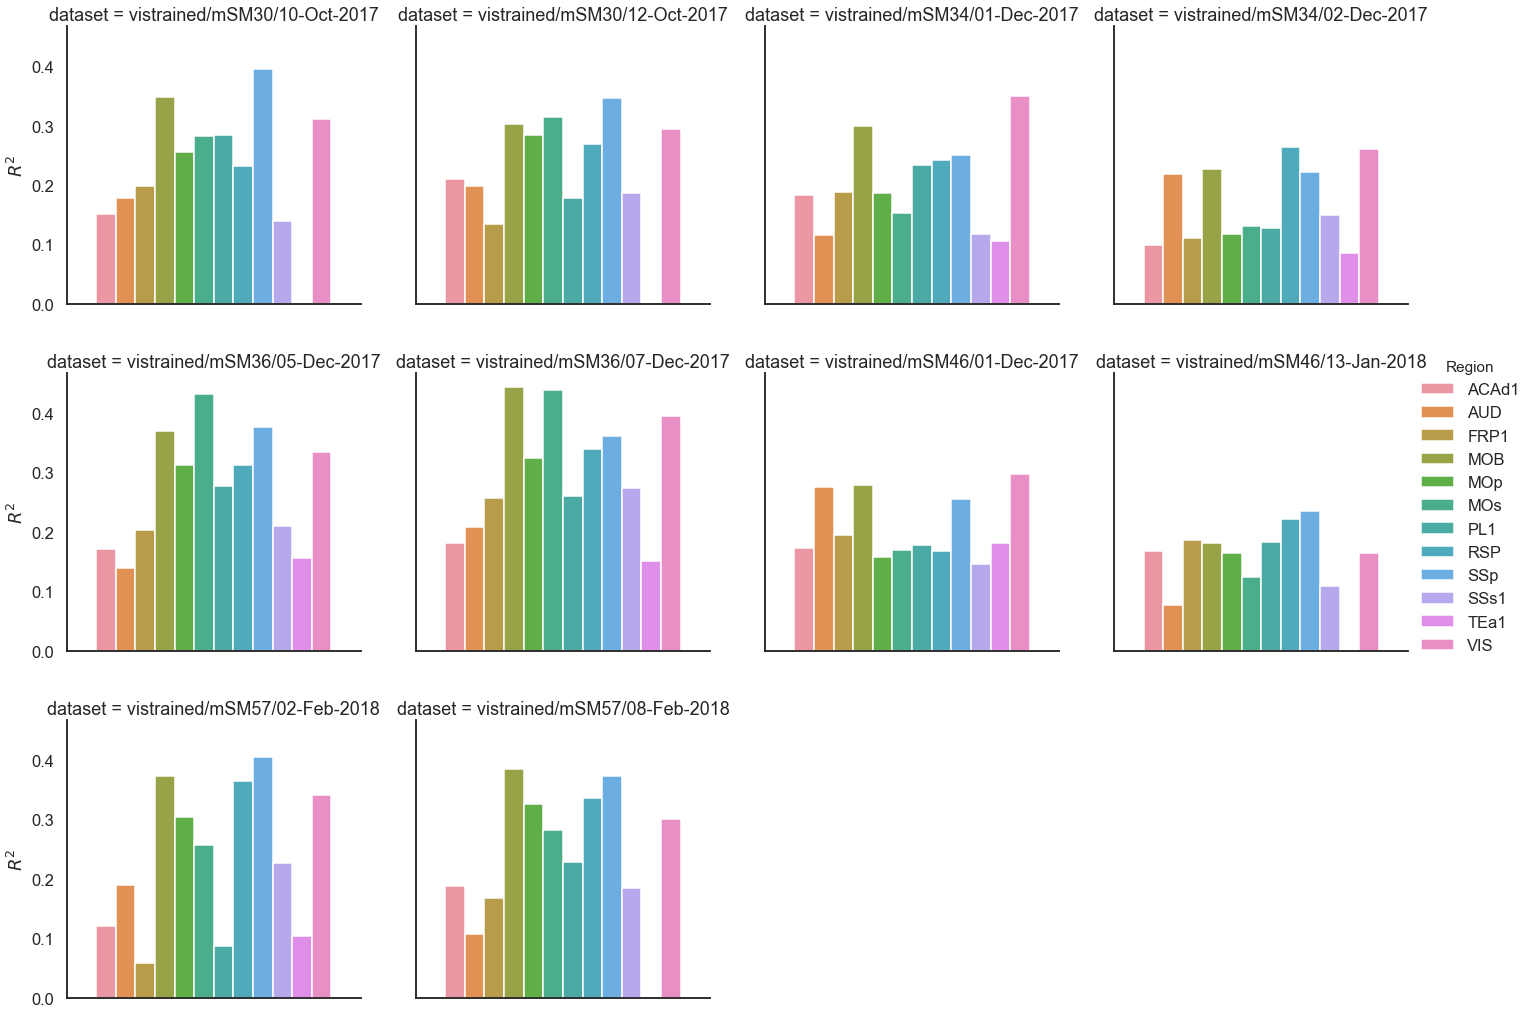

In [67]:
sns.set_style('white'); sns.set_context('talk')
data_queried = all_test_r2s_df.groupby(['region', 'dataset']).max().reset_index()
splt = sns.catplot(
    x='n_lags', y='r2', hue='region', kind='bar', col='dataset', col_wrap=4,
    data=data_queried)
# splt.ax.set_ylabel('$R^2$')
# splt.ax.set_xlabel('Neural lags')
splt._legend.set_title('Region')
# splt.ax.set_ylim([-0.1, 0.2])
for ax in splt.axes:
    ax.set_xlabel('')
    ax.set_xticklabels('')
    if len(ax.get_ylabel()) > 0:
        ax.set_ylabel('$R^2$')
    
if save_outputs:
    save_file = os.path.join(
        results_dir, '%s_decoder_R2s_by_dataset-region' % hparams['lab'])
else:
    save_file = None
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')    
plt.show()